In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
from gym import spaces

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
# https://www.gymlibrary.ml/environments/box2d/lunar_lander/

In [3]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
def get_actor(num_states, num_actions, upper_bound, continuous=True, layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    
    # Different output activation based on discrete or continous version
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(num_actions, activation="softmax", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(num_states, num_actions, layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)

    outputs = layers.Dense(num_actions)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
class Agent:
    def __init__(self, num_states, num_actions, lower_bound, upper_bound, continuous=True,
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005):
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        
        # For methods
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.continuous = continuous

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        self.actor_model = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=400, layer2=300)
        self.critic_model = get_critic(num_states, num_actions, layer1=400, layer2=300)

        self.target_actor = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=400, layer2=300)
        self.target_critic = get_critic(num_states, num_actions, layer1=400, layer2=300)
        
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critic_lr,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=actor_lr,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
        
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
    
    # Move the update and learn function from buffer to Agent to "decrease" scope
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch,):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        
    def policy(self, state, noise_object=0, use_noise=True, noise_mult=1):
        # Default noise_object to 0 for when it is not needed
        # For doing actions without added noise
        if not use_noise:     
            sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
            legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)

            return [np.squeeze(legal_action)]
        else:
            sampled_actions = tf.squeeze(self.actor_model(state))
            noise = noise_object()
            # Adding noise to action
            sampled_actions = sampled_actions.numpy() + noise * noise_mult

            # We make sure action is within bounds
            legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)

            return [np.squeeze(legal_action)]

In [6]:
def fixed(x, episode):
    return x

In [7]:
def run(total_trials=3, total_episodes=100, 
            buffer_capacity=100000, batch_size=64, std_dev=0.2, critic_lr=0.002, render=False,
            actor_lr=0.001, gamma=0.99, tau=0.005, noise_mult=1, save_weights=False, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=40, output=True,
            return_rewards=False, total_time=True, use_guide=False, solved=200,
            continuous=True, environment='LunarLander-v2', seed=1453, start_steps=0,
            gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5):
    tot_time = time.time()
    
    if environment == 'LunarLander-v2':
        env = gym.make(
            "LunarLander-v2",
            continuous=continuous,
            gravity=gravity,
            enable_wind=enable_wind,
            wind_power=wind_power,
            turbulence_power=turbulence_power
        )
    else:
        env = gym.make(environment)
        
    # Apply the seed
    _ = env.reset(seed=seed)
    
    # Stepcount for random start
    step = 0
        
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):

        # add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=buffer_capacity, 
                batch_size=batch_size, std_dev=std_dev, critic_lr=critic_lr, actor_lr=actor_lr, 
                gamma=gamma, tau=tau)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, noise_mult=noise_mult)
                    # To get the right format
                    action = action[0]
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    # giving penalty for straying far from flags and having high speed
                    # x max
#                     reward -= int(abs(state[0]) > 0.15) * 2 * abs(state[0])
#                     # y top
#                     reward -= int(state[1] > 1) * state[1] / 2
#                     # horizontal speed
#                     reward -= int(abs(state[2]) > 1) * abs(state[2])
#                     # down speed
#                     reward -= int(state[3] <  -1) * abs(state[3])
#                     # up speed
#                     reward -= int(state[3] > 0.1) * 3 * state[3]
                    reward -= abs(state[2]/2) + abs(state[3]) + (abs(state[0])) + (abs(state[1])/2)

                agent.record((prev_state, action, reward, state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                # End this episode if en episode is done
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            
            true_reward_list[trial].append(true_reward)
            
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)

            # Mean of last x episodes
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, true_reward, (time.time() - before), step))
            avg_reward_list[trial].append(avg_reward)
            
            # stop if avg is solved
            if true_avg_reward >= solved:
                break

        if save_weights:
            agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '.h5')
            agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '.h5')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    plt.show()
    
    print('total time:',time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [23]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False,
        environment="LunarLander-v2", continuous=True, gravity=-10.0, enable_wind=False,
        wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power
    )
    
        # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=0, batch_size=0, 
                std_dev=0, critic_lr=0, actor_lr=0, gamma=0, tau=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(state=tf_prev_state, use_noise=False)
            action = action[0]
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [29]:
def random(total_episodes=10, render=False, environment="LunarLander-v2", continuous=True,
        gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
    )
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            print(action)
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [10]:
def a(x, episode):
    if (episode % 2 == 1):
        return 0.2
    else:
        return 0.5

0
3
0
1
1
2
2
3
2
2
2
1
2
3
2
2
2
0
3
1
3
3
3
3
2
2
0
0
3
3
2
0
0
1
3
3
1
2
0
1
0
0
3
3
0
3
2
3
1
2
0
0
2
1
0
2
3
3
1
1
3
3
2
1
2
0
0
1
2
0
1
0
3
3
1
1
0
1
2
3
3
3
0
0
3
2
3
2
3
0
3
3
2
2
2
1
2
2
3
0
3
1
3
2
0
0
0
0
0.019032955169677734s
0
1
2
3
3
3
0
1
1
0
3
0
2
2
1
2
1
2
1
3
3
2
3
2
0
2
3
2
2
1
0
0
1
0
0
1
0
2
2
2
3
2
2
2
0
1
0
2
2
3
2
0
2
2
2
3
0
0
0
1
2
1
1
2
2
3
3
1
3
3
3
3
1
2
1
2
3
1
3
1
0
1
0
3
2
1
0
1
3
0
2
0.013005256652832031s
3
0
2
0
2
3
3
2
0
0
1
1
0
3
1
0
3
0
2
1
1
1
2
0
0
1
0
3
1
3
0
2
0
1
1
3
2
1
0
0
3
2
3
0
2
0
2
2
1
1
2
3
2
0
0
2
2
1
2
2
2
3
2
2
2
0
1
1
0
0
0
0
3
0
2
1
2
1
1
3
2
2
3
1
2
0
2
1
1
0
0
1
3
3
3
0
1
3
3
0
3
0
1
2
1
2
0
3
0
1
0
1
0.012908220291137695s
0
0
2
3
1
3
0
3
0
0
1
0
3
2
3
3
1
0
0
2
0
3
3
1
1
3
1
3
3
1
2
0
0
1
0
3
0
0
1
3
1
0
0
2
0
2
1
3
2
3
0
1
3
0
2
3
1
0
1
1
2
3
1
1
3
0
2
3
3
1
2
3
3
2
0
0
3
1
1
2
0.008040189743041992s
2
3
0
3
2
1
2
3
0
0
0
1
2
0
2
0
1
2
2
1
2
3
2
0
2
0
1
0
0
3
0
1
1
3
2
0
3
2
0
2
0
0
3
0
3
0
2
3
2
1
1
3
2
3
2
3
2
3
2
3
0
3
3
1
0


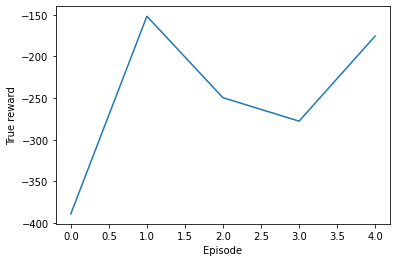

In [30]:
random(total_episodes=5, render=False, continuous=False)

Ep 0 * AvgReward -590.28 * true AvgReward -590.28 * Reward -590.28 * True Reward -590.28 * time 2.25 * step 133
Ep 1 * AvgReward -302.88 * true AvgReward -302.88 * Reward -15.48 * True Reward -15.48 * time 1.04 * step 221
Ep 2 * AvgReward -207.57 * true AvgReward -207.57 * Reward -16.96 * True Reward -16.96 * time 1.27 * step 329
Ep 3 * AvgReward -222.52 * true AvgReward -222.52 * Reward -267.34 * True Reward -267.34 * time 1.30 * step 440
Ep 4 * AvgReward -195.05 * true AvgReward -195.05 * Reward -85.18 * True Reward -85.18 * time 1.29 * step 551
Ep 5 * AvgReward -236.79 * true AvgReward -236.79 * Reward -445.52 * True Reward -445.52 * time 1.82 * step 707
Ep 6 * AvgReward -236.29 * true AvgReward -236.29 * Reward -233.29 * True Reward -233.29 * time 1.03 * step 795
Ep 7 * AvgReward -204.47 * true AvgReward -204.47 * Reward 18.33 * True Reward 18.33 * time 1.41 * step 908
Ep 8 * AvgReward -223.95 * true AvgReward -223.95 * Reward -379.81 * True Reward -379.81 * time 1.43 * step 1033
E

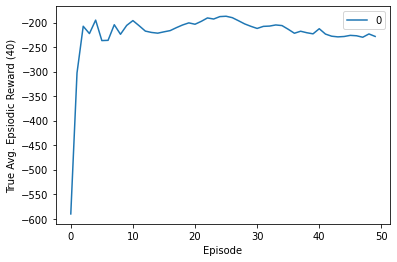

total time: 62.089587450027466 s


In [17]:
run(total_trials=1, total_episodes=50, start_steps=10000, save_weights=True)

In [15]:
run(total_trials=1, total_episodes=200, start_steps=1000, continuous=False)

C:\ProgramData\Miniconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Ep 0 * AvgReward -391.55 * true AvgReward -391.55 * Reward -391.55 * True Reward -391.55 * time 1.25 * step 92
Ep 1 * AvgReward -303.08 * true AvgReward -303.08 * Reward -214.60 * True Reward -214.60 * time 0.55 * step 196
Ep 2 * AvgReward -242.97 * true AvgReward -242.97 * Reward -122.76 * True Reward -122.76 * time 0.57 * step 299
Ep 3 * AvgReward -213.83 * true AvgReward -213.83 * Reward -126.39 * True Reward -126.39 * time 1.01 * step 392
Ep 4 * AvgReward -200.02 * true AvgReward -200.02 * Reward -144.79 * True Reward -144.79 * time 1.26 * step 503
Ep 5 * AvgReward -191.97 * true AvgReward -191.97 * Reward -151.74 * True Reward -151.74 * time 0.94 * step 591
Ep 6 * AvgReward -180.51 * true AvgReward -180.51 * Reward -111.74 * True Reward -111.74 * time 0.77 * step 660
Ep 7 * AvgReward -173.51 * true AvgReward -173.51 * Reward -124.54 * True Reward -124.54 * time 0.89 * step 740
Ep 8 * AvgReward -184.38 * true AvgReward -184.38 * Reward -271.31 * True Reward -271.31 * time 1.16 * st

AssertionError: array(1.) (<class 'numpy.ndarray'>) invalid 

1.648961067199707s
1.7340922355651855s
1.4222650527954102s


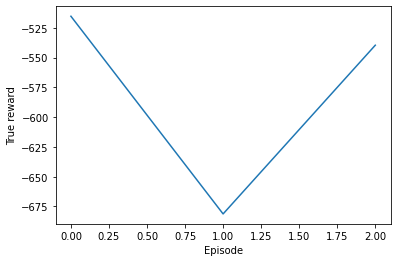

In [25]:
test(render=True, total_episodes=3)